In [5]:
# Install required packages
install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
                   "knitr", "gridExtra", "MASS", "lawstat",
                   "FinTS", "ggthemes", "lubridate"))

Installing packages into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message:
“package ‘MASS’ is not available for this version of R
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.4.0)
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.6)
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.5)

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
also installing the dependency ‘timechange’




In [6]:
suppressPackageStartupMessages({
  library(ggplot2)    # Data visualization
  library(forecast)   # Time series analysis (excluding auto.arima)
  library(tseries)    # Additional time series tests
  library(dplyr)      # Data manipulation
  library(lubridate)  # Date handling
  library(gridExtra)  # Multiple plot arrangement
  library(MASS)       # Statistical functions
  library(knitr)      # For table formatting
  library(lawstat)    # For runs test
  library(FinTS)      # For ARCH test
})


In [7]:
# Plot theme setting

theme_tsa <- function() {
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.title = element_text(face = "bold"),
    legend.position = "bottom",
    panel.grid.minor = element_line(color = "gray90"),
    panel.grid.major = element_line(color = "gray85")
  )
}
options(repr.plot.width = 20, repr.plot.height = 10)

# ==========================================
# 1. DATA LOADING AND VALIDATION
# ==========================================

In [8]:
temp_data <- tryCatch({
  read.csv("../data/algiers_temp.csv")
}, error = function(e) {
  message("Error loading data: ", e$message)
  return(NULL)
})

In [9]:
if(!is.null(temp_data)) {
  temp_data$time <- as.Date(temp_data$time)
  missing_values <- sum(is.na(temp_data$temperature))
  cat("Missing values in temperature:", missing_values, "\n")

  is_ordered <- all(diff(temp_data$time) > 0)
  cat("Data is temporally ordered:", is_ordered, "\n")

  cat("\nDataset summary:\n")
  print(summary(temp_data))

  cat("\nDate range:", format(min(temp_data$time), "%Y-%m-%d"), 
      "to", format(max(temp_data$time), "%Y-%m-%d"), "\n")

  cat("Temperature range:", min(temp_data$temperature), 
      "to", max(temp_data$temperature), "°C\n")
}

Missing values in temperature: 0 
Data is temporally ordered: TRUE 

Dataset summary:
      time             temperature   
 Min.   :2002-01-01   Min.   : 2.00  
 1st Qu.:2007-06-02   1st Qu.:12.70  
 Median :2012-10-31   Median :17.20  
 Mean   :2012-10-31   Mean   :17.86  
 3rd Qu.:2018-04-01   3rd Qu.:23.30  
 Max.   :2023-08-31   Max.   :36.70  

Date range: 2002-01-01 to 2023-08-31 
Temperature range: 2 to 36.7 °C


# ==========================================
# 2. ENHANCED VISUALIZATION
# ==========================================

`geom_smooth()` using formula = 'y ~ x'


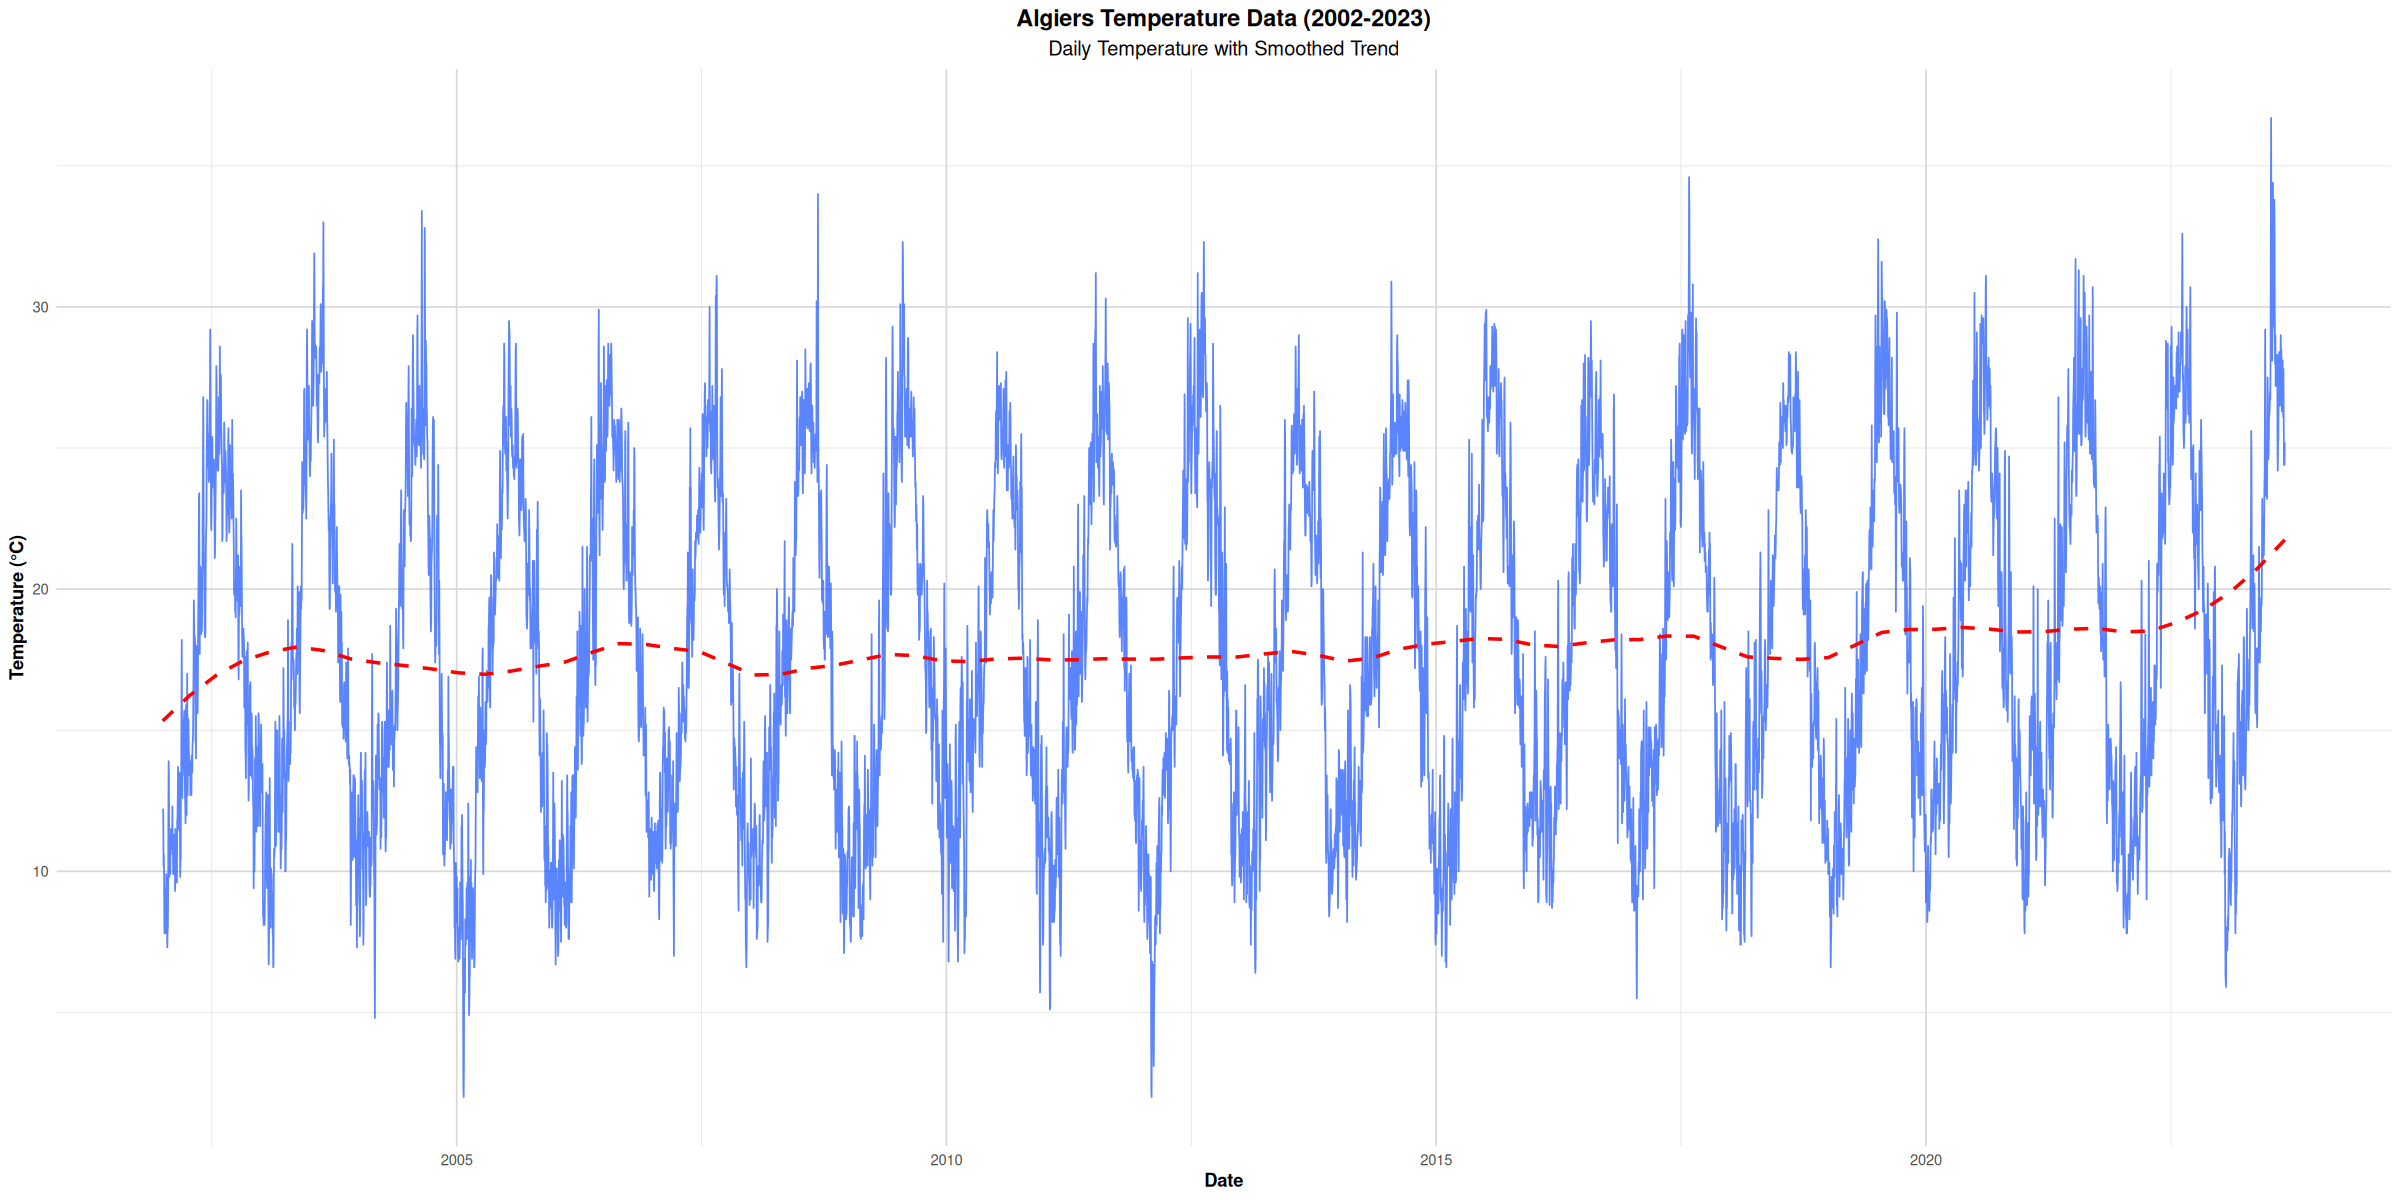

In [10]:
p1 <- ggplot(temp_data, aes(x = time, y = temperature)) +
  geom_line(color = "#3366FF", alpha = 0.8) +
  geom_smooth(method = "loess", span = 0.2, se = FALSE, 
              color = "red", linetype = "dashed") +
  labs(
    title = "Algiers Temperature Data (2002-2023)",
    subtitle = "Daily Temperature with Smoothed Trend",
    x = "Date", 
    y = "Temperature (°C)"
  ) +
  theme_tsa()

print(p1)

In [11]:
# extracting years and month for monthly analysis
temp_data <- temp_data %>%
  mutate(
    year = year(time),
    month = month(time),
    month_name = factor(month.abb[month], levels = month.abb)
  )

# Calculate monthly averages
monthly_avg <- temp_data %>%
  group_by(year, month, month_name) %>%
  summarize(avg_temp = mean(temperature, na.rm = TRUE), .groups = "drop")

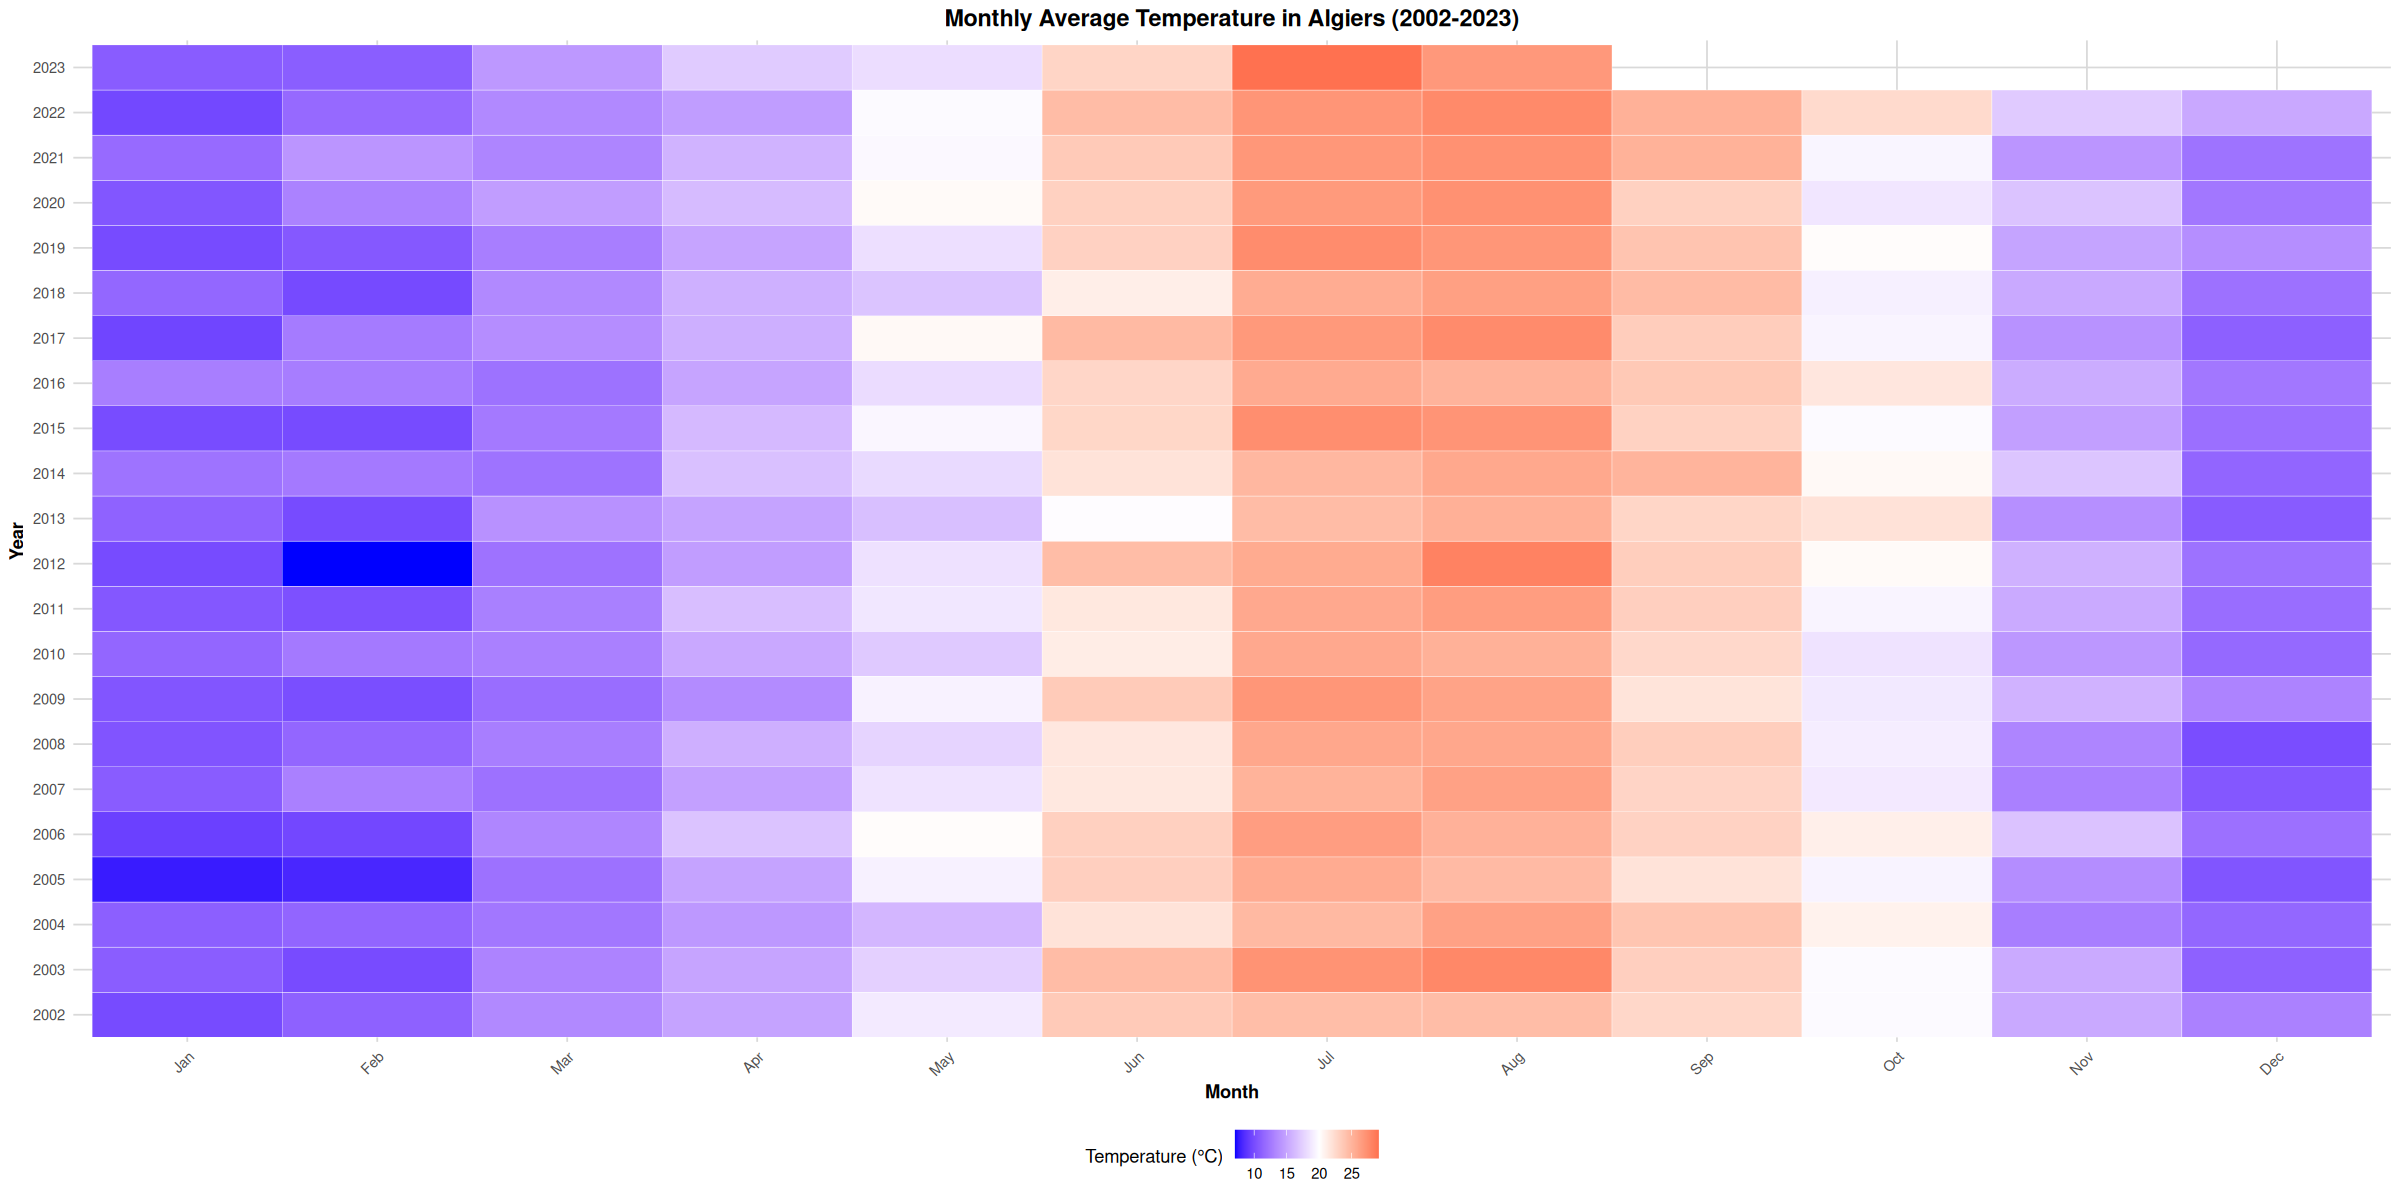

In [12]:
p2 <- ggplot(monthly_avg, aes(x = month_name, y = factor(year), fill = avg_temp)) +
  geom_tile(color = "white", linewidth = 0.1) +
  scale_fill_gradient2(
    low = "blue", mid = "white", high = "red", 
    midpoint = 20, 
    name = "Temperature (°C)"
  ) +
  labs(
    title = "Monthly Average Temperature in Algiers (2002-2023)",
    x = "Month", 
    y = "Year"
  ) +
  theme_tsa() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid = element_blank()
  )

print(p2)

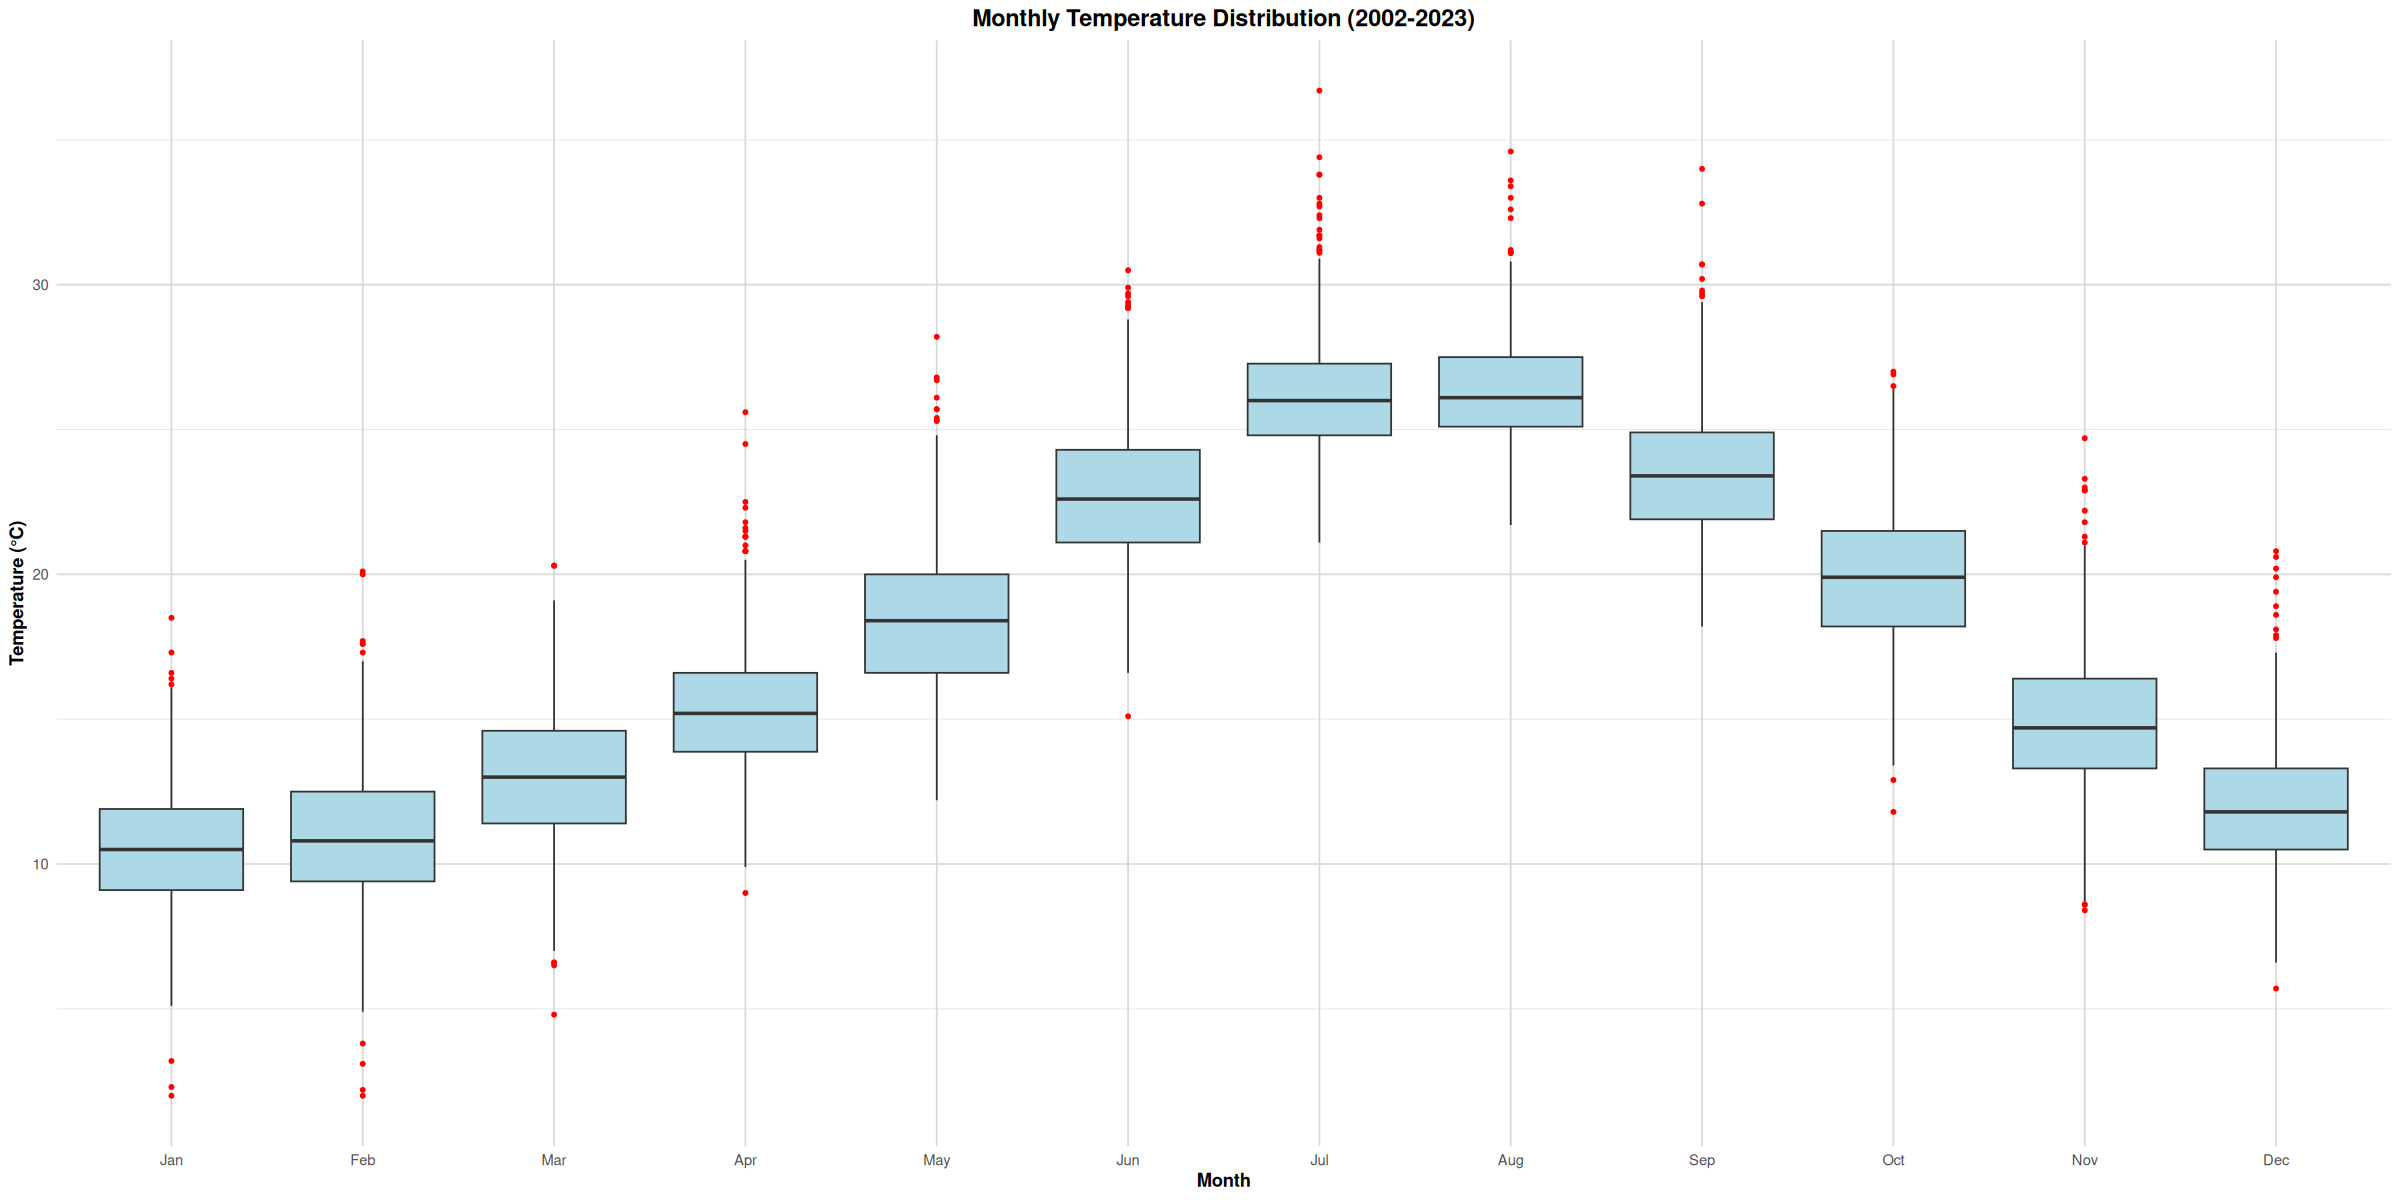

In [13]:
p3 <- ggplot(temp_data, aes(x = month_name, y = temperature, group = month_name)) +
  geom_boxplot(fill = "lightblue", outlier.color = "red", outlier.size = 1) +
  labs(
    title = "Monthly Temperature Distribution (2002-2023)",
    x = "Month", 
    y = "Temperature (°C)"
  ) +
  theme_tsa()

print(p3)

# ==========================================
# 3. TIME SERIES PREPARATION
# ==========================================

In [14]:
# create time series object

monthly_temps <- temp_data %>%
  group_by(year, month) %>%
  summarize(temperature = mean(temperature, na.rm = TRUE), .groups = "drop") %>%
  arrange(year, month)

monthly_temp_ts <- ts(monthly_temps$temperature, 
                      frequency = 12, 
                      start = c(min(monthly_temps$year), 1))

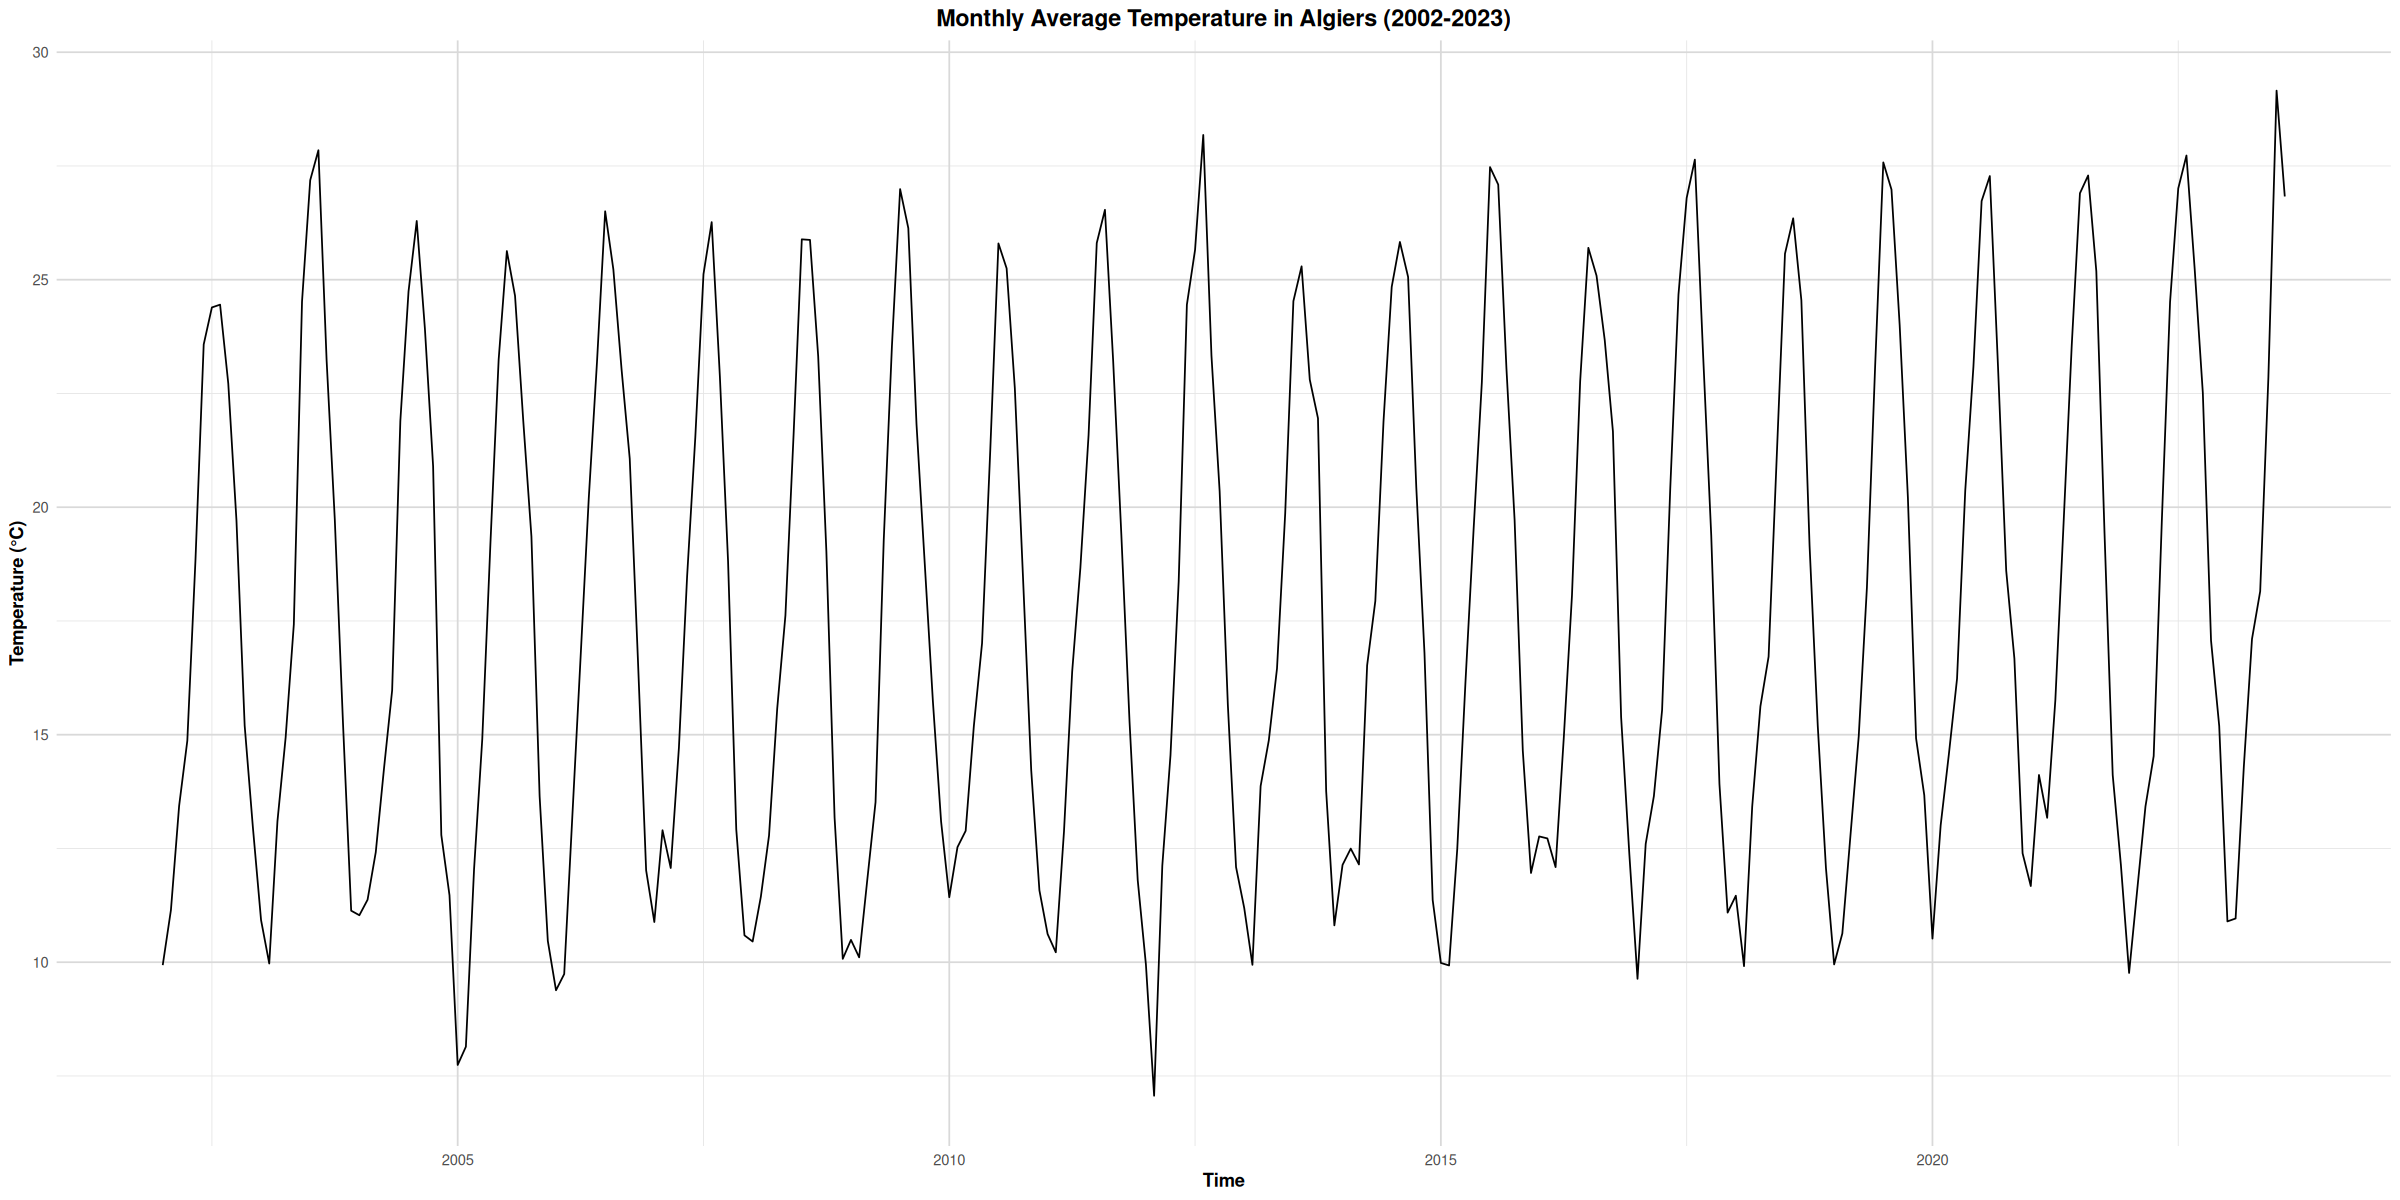

In [15]:
autoplot(monthly_temp_ts) +
  labs(
    title = "Monthly Average Temperature in Algiers (2002-2023)",
    x = "Time", 
    y = "Temperature (°C)"
  ) +
  theme_tsa()

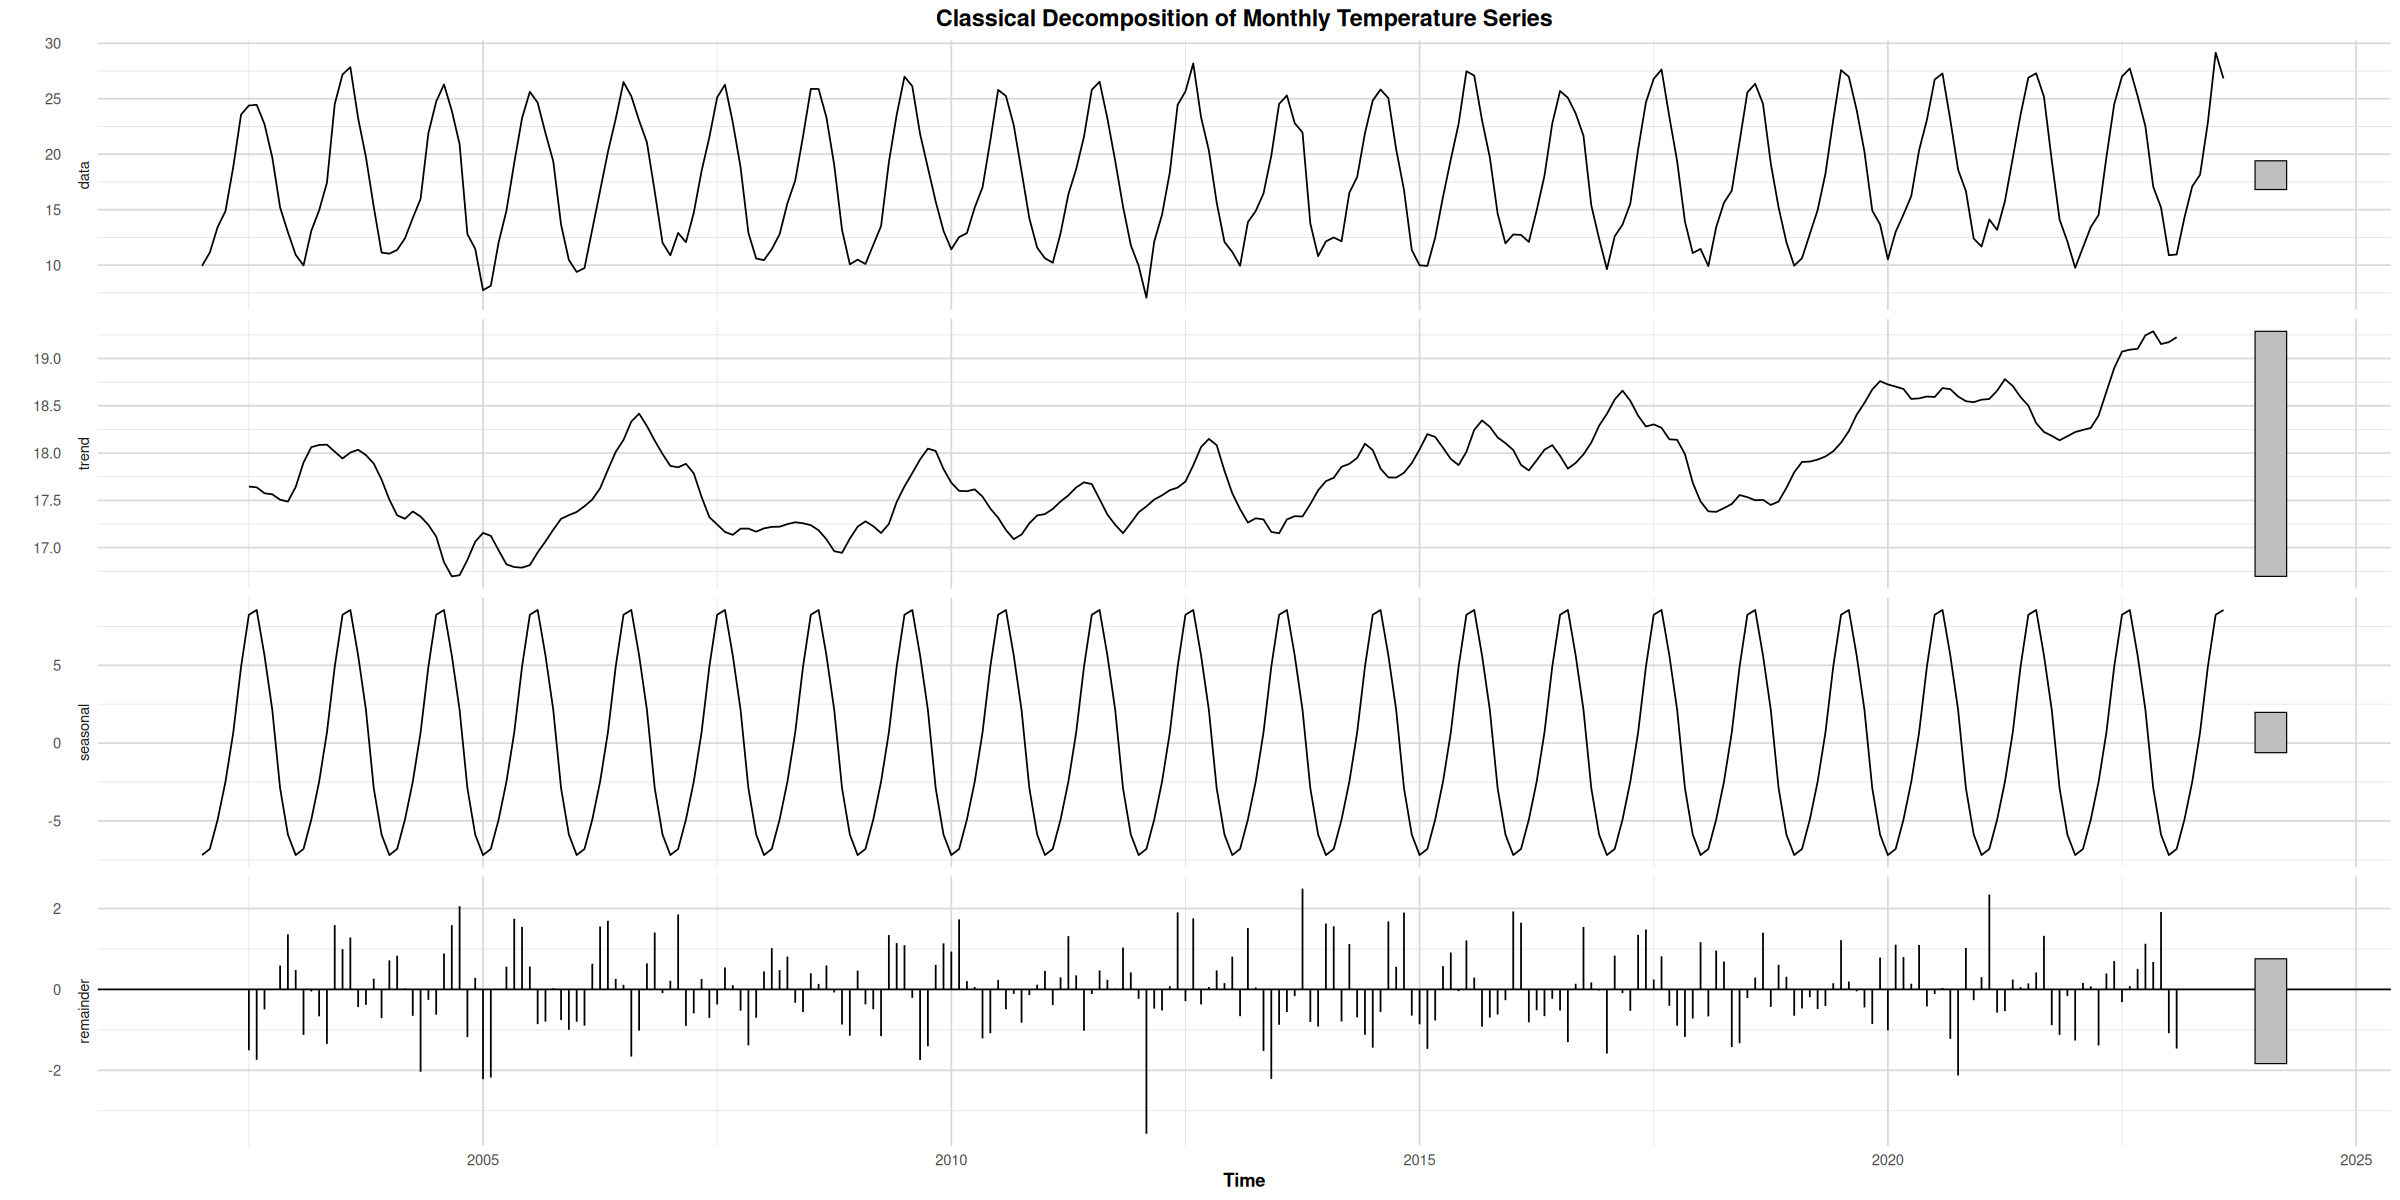

In [ ]:
# decomposition to show different components of time series

monthly_decomp <- decompose(monthly_temp_ts)
autoplot(monthly_decomp) +
  labs(title = "Classical Decomposition of Monthly Temperature Series") +
  theme_tsa()

# ==========================================
# 4. STATIONARITY ANALYSIS
# ==========================================

In [20]:
cat("ADF & KPSS Test for Monthly Temperature:\n")
adf_test <- adf.test(monthly_temp_ts)
kpss_test <- kpss.test(monthly_temp_ts)

print(adf_test)
print(kpss_test)

if (adf_test$p.value >= 0.05) {
  cat("ADF test: The monthly series is NOT stationary (p >= 0.05)\n")
} else {
  cat("ADF test: The monthly series is stationary (p < 0.05)\n")
}

if (kpss_test$p.value < 0.05) {
  cat("KPSS test: The monthly series is NOT stationary (p < 0.05)\n")
} else {
  cat("KPSS test: The monthly series is stationary (p >= 0.05)\n")
}

ADF & KPSS Test for Monthly Temperature:


Warning message in adf.test(monthly_temp_ts):
“p-value smaller than printed p-value”
Warning message in kpss.test(monthly_temp_ts):
“p-value greater than printed p-value”



	Augmented Dickey-Fuller Test

data:  monthly_temp_ts
Dickey-Fuller = -14.21, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  monthly_temp_ts
KPSS Level = 0.083766, Truncation lag parameter = 5, p-value = 0.1

ADF test: The monthly series is stationary (p < 0.05)
KPSS test: The monthly series is stationary (p >= 0.05)


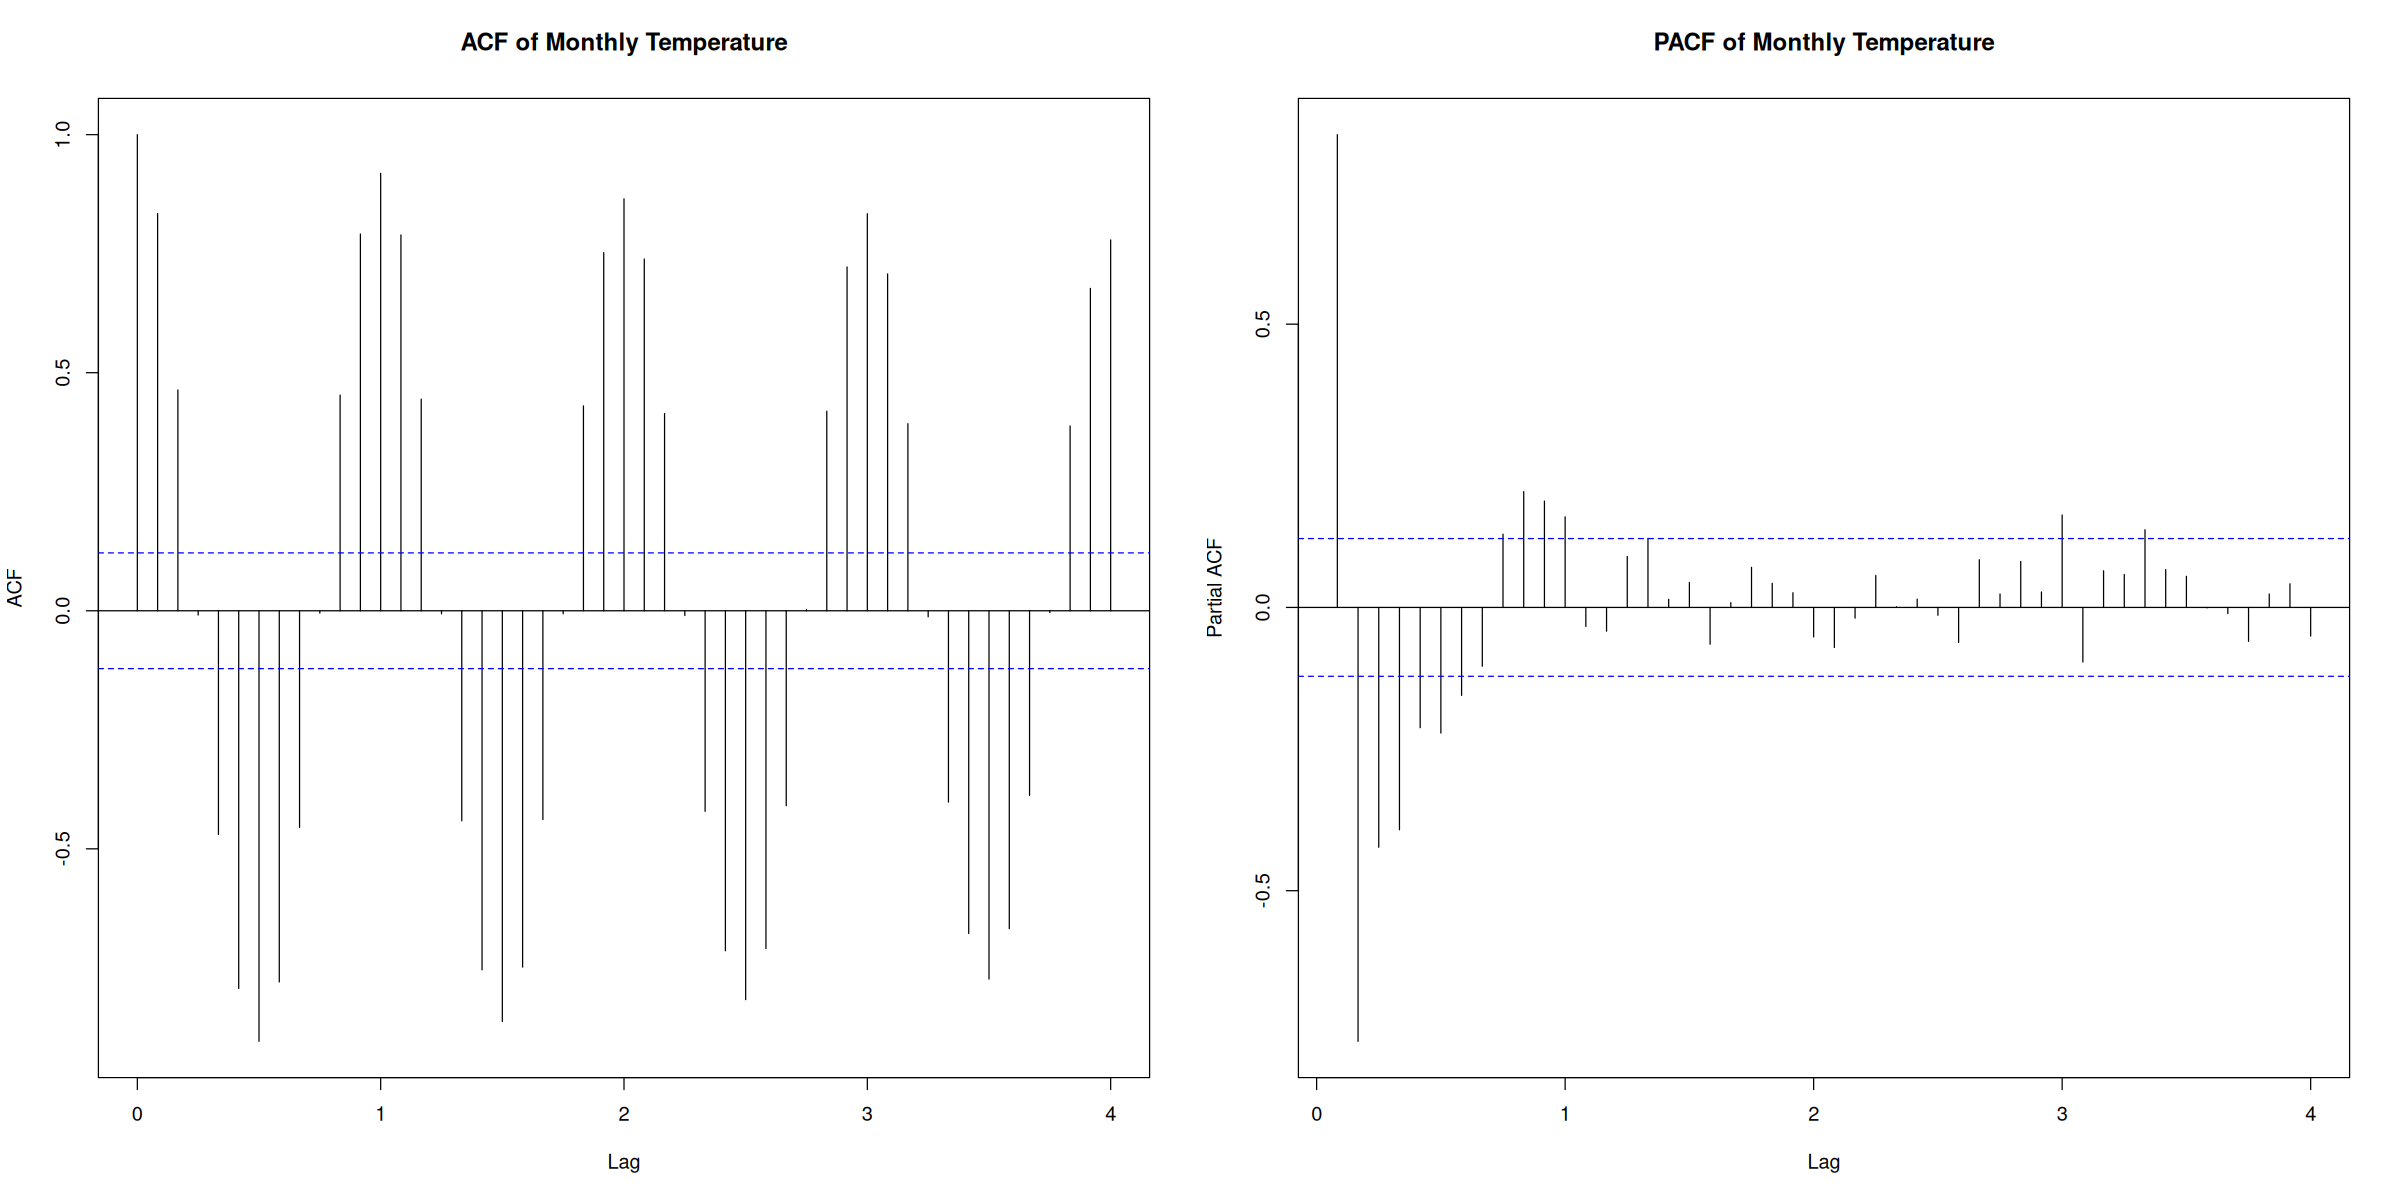

In [23]:
par(mfrow = c(1, 2),bg = "white")
acf(monthly_temp_ts, main = "ACF of Monthly Temperature", lag.max = 48)
pacf(monthly_temp_ts, main = "PACF of Monthly Temperature", lag.max = 48)
par(mfrow = c(1, 1))